# Drive Mount

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Preporcessing**

*Path for frames*

In [4]:
import os

BASE_DIR = "/content/drive/MyDrive/deepfake_project"

RAW_VIDEO_DIR = os.path.join(BASE_DIR, "raw_videos")
FACE_CROP_DIR = os.path.join(BASE_DIR, "face_crops")

os.makedirs(FACE_CROP_DIR, exist_ok=True)

print("Paths ready")


Paths ready


*Frames Extractions*

In [5]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import mediapipe as mp

# Paths
BASE_DIR = "/content/drive/MyDrive/deepfake_project"
RAW_VIDEO_DIR = os.path.join(BASE_DIR, "raw_videos")
FACE_CROP_DIR = os.path.join(BASE_DIR, "face_crops")

os.makedirs(os.path.join(FACE_CROP_DIR, "real"), exist_ok=True)
os.makedirs(os.path.join(FACE_CROP_DIR, "fake"), exist_ok=True)

# Correct video folders
REAL_DIR = os.path.join(RAW_VIDEO_DIR, "Celeb-real")
FAKE_DIR = os.path.join(RAW_VIDEO_DIR, "Celeb-synthesis")

# MediaPipe
mp_face = mp.solutions.face_detection
face_detector = mp_face.FaceDetection(
    model_selection=1,
    min_detection_confidence=0.5
)

def sample_frames(video_path, num_frames=5):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_ids = np.linspace(0, total - 1, num_frames, dtype=int) if total > num_frames else range(total)
    frames = []

    for fid in frame_ids:
        cap.set(cv2.CAP_PROP_POS_FRAMES, fid)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)

    cap.release()
    return frames

def extract_face(image):
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_detector.process(rgb)

    if not results.detections:
        return None

    h, w, _ = image.shape
    bbox = results.detections[0].location_data.relative_bounding_box

    x1 = int(bbox.xmin * w)
    y1 = int(bbox.ymin * h)
    x2 = int((bbox.xmin + bbox.width) * w)
    y2 = int((bbox.ymin + bbox.height) * h)

    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)

    face = image[y1:y2, x1:x2]
    if face.size == 0:
        return None

    return cv2.resize(face, (224, 224))

def process_videos(video_dir, label, max_videos):
    save_dir = os.path.join(FACE_CROP_DIR, label)
    videos = [v for v in os.listdir(video_dir) if v.endswith(".mp4")][:max_videos]

    for video in tqdm(videos):
        video_path = os.path.join(video_dir, video)
        frames = sample_frames(video_path, num_frames=5)

        for i, frame in enumerate(frames):
            face = extract_face(frame)
            if face is None:
                continue
            out_name = f"{video.replace('.mp4','')}_f{i}.jpg"
            cv2.imwrite(os.path.join(save_dir, out_name), face)

print("✅ All functions reloaded")


ModuleNotFoundError: No module named 'mediapipe'

In [20]:
process_videos(REAL_DIR, label="real", max_videos=350)
process_videos(FAKE_DIR, label="fake", max_videos=1500)


100%|██████████| 1500/1500 [26:26<00:00,  1.06s/it]


In [22]:
import os
len(os.listdir("/content/drive/MyDrive/deepfake_project/face_crops/real"))


1738

*Spiltting*

In [23]:
import os, shutil, random
from collections import defaultdict

BASE = "/content/drive/MyDrive/deepfake_project/face_crops"
SRC_REAL = os.path.join(BASE, "real")
SRC_FAKE = os.path.join(BASE, "fake")

SPLITS = ["train", "val", "test"]
LABELS = ["real", "fake"]

for s in SPLITS:
    for l in LABELS:
        os.makedirs(os.path.join(BASE, s, l), exist_ok=True)

random.seed(42)


In [25]:
def group_by_video(src_dir):
    groups = defaultdict(list)
    for f in os.listdir(src_dir):
        if f.endswith(".jpg"):
            vid = f.rsplit("_f", 1)[0]
            groups[vid].append(f)
    return list(groups.items())


In [26]:
def split_and_move(src_dir, label, tr=0.7, vr=0.15):
    videos = group_by_video(src_dir)
    random.shuffle(videos)

    n = len(videos)
    n_tr = int(tr * n)
    n_va = int(vr * n)

    parts = {
        "train": videos[:n_tr],
        "val": videos[n_tr:n_tr+n_va],
        "test": videos[n_tr+n_va:]
    }

    for split, items in parts.items():
        for vid, files in items:
            for f in files:
                shutil.move(
                    os.path.join(src_dir, f),
                    os.path.join(BASE, split, label, f)
                )

    print(f"{label.upper()} videos → "
          f"Train {len(parts['train'])}, "
          f"Val {len(parts['val'])}, "
          f"Test {len(parts['test'])}")


In [27]:
split_and_move(SRC_REAL, "real")
split_and_move(SRC_FAKE, "fake")


REAL videos → Train 244, Val 52, Test 54
FAKE videos → Train 1050, Val 225, Test 225


# Model Training

In [4]:
!pip install -q torch torchvision timm


In [ ]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Found existing installation: torch 2.7.1+cu118
Uninstalling torch-2.7.1+cu118:
  Successfully uninstalled torch-2.7.1+cu118
Found existing installation: torchvision 0.22.1+cu118
Uninstalling torchvision-0.22.1+cu118:
  Successfully uninstalled torchvision-0.22.1+cu118
Found existing installation: torchaudio 2.7.1+cu118
Uninstalling torchaudio-2.7.1+cu118:
  Successfully uninstalled torchaudio-2.7.1+cu118
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.7.1%2Bcu118-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (28 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.22.1%2Bcu118-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.7.1%2Bcu118-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.6 kB)
Using cached https://download.pytorch.org/whl/cu118/torch-2.7.1%2Bcu118-cp312-cp312-manylinux_2_28_x86_64.whl (905.2 MB)
Using cache

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())


2.7.1+cu118
True


In [7]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm


In [6]:
BASE = "/content/drive/MyDrive/deepfake_project/face_crops"

TRAIN_DIR = f"{BASE}/train"
VAL_DIR   = f"{BASE}/val"
TEST_DIR  = f"{BASE}/test"


*Transform*

In [8]:
train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])


*Datasets & loaders*

In [9]:
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
val_ds   = datasets.ImageFolder(VAL_DIR, transform=val_tfms)
test_ds  = datasets.ImageFolder(TEST_DIR, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

print(train_ds.class_to_idx)  # {'fake': 0, 'real': 1}


{'fake': 0, 'real': 1}


*Handle class imbalance*

In [10]:
num_fake = sum(1 for _, y in train_ds.samples if y == 0)
num_real = sum(1 for _, y in train_ds.samples if y == 1)

w_fake = 1.0
w_real = num_fake / num_real

class_weights = torch.tensor([w_fake, w_real]).cuda()
print(class_weights)


tensor([1.0000, 4.3245], device='cuda:0')


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = timm.create_model(
    "efficientnet_b0",
    pretrained=True,
    num_classes=2
)

model = model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [12]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [13]:
def train_one_epoch(loader):
    model.train()
    total_loss = 0
    correct = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()

    acc = correct / len(loader.dataset)
    return total_loss, acc


def eval_model(loader):
    model.eval()
    correct = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            correct += (out.argmax(1) == y).sum().item()

    acc = correct / len(loader.dataset)
    return acc


*Training Run*

In [14]:
for epoch in range(10):
    loss, train_acc = train_one_epoch(train_loader)
    val_acc = eval_model(val_loader)

    print(f"Epoch {epoch+1}: "
          f"Loss {loss:.3f} | "
          f"Train Acc {train_acc:.3f} | "
          f"Val Acc {val_acc:.3f}")


Epoch 1: Loss 214.536 | Train Acc 0.747 | Val Acc 0.809
Epoch 2: Loss 55.077 | Train Acc 0.907 | Val Acc 0.865
Epoch 3: Loss 26.841 | Train Acc 0.956 | Val Acc 0.894
Epoch 4: Loss 14.806 | Train Acc 0.976 | Val Acc 0.905
Epoch 5: Loss 12.313 | Train Acc 0.982 | Val Acc 0.922
Epoch 6: Loss 6.170 | Train Acc 0.988 | Val Acc 0.925
Epoch 7: Loss 4.430 | Train Acc 0.992 | Val Acc 0.919
Epoch 8: Loss 3.669 | Train Acc 0.994 | Val Acc 0.926
Epoch 9: Loss 1.844 | Train Acc 0.996 | Val Acc 0.925
Epoch 10: Loss 5.536 | Train Acc 0.990 | Val Acc 0.931


In [17]:
import os

MODEL_DIR = "/content/drive/MyDrive/deepfake_project/models"
os.makedirs(MODEL_DIR, exist_ok=True)

print("Model directory:", MODEL_DIR)


Model directory: /content/drive/MyDrive/deepfake_project/models


In [18]:
import torch

final_model_path = f"{MODEL_DIR}/final_efficientnet_b0.pth"

torch.save(
    {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": 10,
        "train_acc": train_acc,
        "val_acc": val_acc
    },
    final_model_path
)

print("✅ Final model saved at:", final_model_path)


✅ Final model saved at: /content/drive/MyDrive/deepfake_project/models/final_efficientnet_b0.pth


In [19]:
import torch
import os

MODEL_DIR = "/content/drive/MyDrive/deepfake_project/models"
os.makedirs(MODEL_DIR, exist_ok=True)

best_model_path = f"{MODEL_DIR}/best_efficientnet_b0.pth"

torch.save(
    {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "note": "Best model based on validation accuracy (~0.926)"
    },
    best_model_path
)

print("⭐ Best model saved at:", best_model_path)


⭐ Best model saved at: /content/drive/MyDrive/deepfake_project/models/best_efficientnet_b0.pth


# TESTING

Load the BEST model

In [20]:
import torch
import timm
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

model = timm.create_model(
    "efficientnet_b0",
    pretrained=False,
    num_classes=2
)

ckpt = torch.load(
    "/content/drive/MyDrive/deepfake_project/models/best_efficientnet_b0.pth",
    map_location=device
)

model.load_state_dict(ckpt["model_state_dict"])
model = model.to(device)
model.eval()

print("✅ Best model loaded")


✅ Best model loaded


Run inference on TEST set

In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

y_true = []
y_pred = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        preds = out.argmax(1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(y.numpy())


Accuracy,recall,confusion metrix

In [22]:
acc = accuracy_score(y_true, y_pred)
print("Test Accuracy:", acc)

print(classification_report(
    y_true,
    y_pred,
    target_names=["fake", "real"]
))

cm = confusion_matrix(y_true, y_pred)
print(cm)


Test Accuracy: 0.9157667386609071
              precision    recall  f1-score   support

        fake       0.94      0.96      0.95      1125
        real       0.80      0.74      0.77       264

    accuracy                           0.92      1389
   macro avg       0.87      0.85      0.86      1389
weighted avg       0.91      0.92      0.91      1389

[[1076   49]
 [  68  196]]


# Grad CAM

In [25]:
!pip install -q git+https://github.com/jacobgil/pytorch-grad-cam


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [59]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


In [72]:
BASE_TEST_DIR = "/content/drive/MyDrive/deepfake_project/face_crops/test"

label = random.choice(["fake", "real"])
test_dir = os.path.join(BASE_TEST_DIR, label)

img_name = random.choice(os.listdir(test_dir))
img_path = os.path.join(test_dir, img_name)

print(f"Selected {label.upper()} image:", img_name)


Selected FAKE image: id28_id29_0000_f0.jpg


In [61]:
model.eval()
target_layers = [model.conv_head]

cam = GradCAM(
    model=model,
    target_layers=target_layers
)


generate heatmap

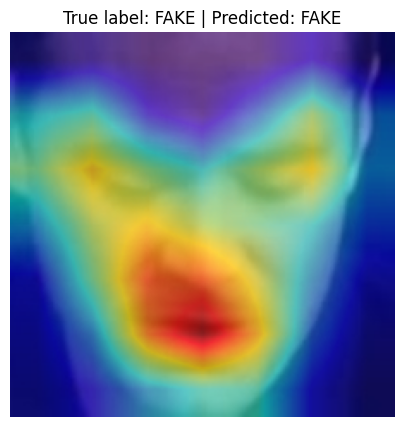

In [73]:
# Load image
image = Image.open(img_path).convert("RGB")
input_tensor = preprocess(image).unsqueeze(0).to(device)

# Forward pass
outputs = model(input_tensor)
pred_class = outputs.argmax(dim=1).item()

targets = [ClassifierOutputTarget(pred_class)]

# Grad-CAM
grayscale_cam = cam(
    input_tensor=input_tensor,
    targets=targets
)[0]

# Overlay
img_np = np.array(image).astype(np.float32) / 255.0
visualization = show_cam_on_image(
    img_np,
    grayscale_cam,
    use_rgb=True
)

# Plot
plt.figure(figsize=(5, 5))
plt.imshow(visualization)
plt.axis("off")
plt.title(
    f"True label: {label.upper()} | Predicted: {'FAKE' if pred_class==0 else 'REAL'}"
)
plt.show()


In [69]:
out_path = "/content/drive/MyDrive/deepfake_project/results/gradcam_fake_1.png"
os.makedirs(os.path.dirname(out_path), exist_ok=True)

plt.imsave(out_path, visualization)
print("Saved:", out_path)


Saved: /content/drive/MyDrive/deepfake_project/results/gradcam_fake_1.png
